In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import dask
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from matplotlib import cm
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from bbl import *
from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [3]:
run_dedalus = False # Dedalus only works on login nodes; MITgcm analysis has to work on compute nodes.

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

### Run / load 1D Dedalus simulations

In [5]:
T = 4800*86400
names = ['default', 'f=0', 'Pr=230']

bbl_runs = {
    'default': {},
    'f=0': {'f': 0.},
    'Pr=230': {'σ': 230.},
    'theta=0': {'θ': 0.}
}
bbl_output = {}

for name, kwargs in bbl_runs.items():
    path = f"../../data/dedalus/transient/BBTRE-{name}_{T}.nc"

    if run_dedalus:
        from bbl import *
        bbl = bbl_exp_spinup(T=T, dt=T/100., **kwargs)
        bbl_output[name] = bbl_to_ds(bbl)
        bbl_output[name].to_netcdf(path)
        
    else:
        pathstr = path.split("/")[-1]
        print(f"Loading {pathstr}")
        bbl_output[name] = xr.open_dataset(path)

Loading BBTRE-default_414720000.nc
Loading BBTRE-f=0_414720000.nc
Loading BBTRE-Pr=230_414720000.nc
Loading BBTRE-theta=0_414720000.nc


In [6]:
experiments = ["idealized-plane-1D", "idealized-plane-1D-Pr230", "idealized-plane", "idealized-canyon", "idealized-sill", "canyon-tracer"]

data = {}
for exp in experiments:
    data[exp] = xr.open_dataset(f"../../data/BBTRE-physics/buoyancy_{exp}.nc")
    data[exp] = data[exp].sel(Z=data[exp]['Z'][:-1])
    data[exp].attrs['H'] = data[exp]['Depth'].max(skipna=True).values
    for suffix in ["", "_K-per-year", "_cumint_mSv"]:
        data[exp]["conv_vert_adv_transient_flux_TH"+suffix] = data[exp]["conv_vert_adv_flux_TH"+suffix] - data[exp]["conv_vert_adv_standing_flux_TH"+suffix]

In [7]:
labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Mixing",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_transient_flux_TH": "Transient Eddies",
    "conv_vert_adv_standing_flux_TH": "Standing Eddies"
}

#ds = data["canyon-tracer"]
ds = data["canyon-tracer"]

ds["a"] = ds["a"]/ds["a"].max()
def add_deriv_budget(ds):
    for label in labels.keys():
        ds[f"{label}_K-per-year_z"] = (ds[f"{label}_K-per-year"].rolling({"Z":4}).mean().diff(dim="Z")/ds['Z'].diff(dim="Z"))/(0.5*(ds["a"][1:].values + ds["a"][:-1].values))

In [8]:
add_deriv_budget(ds)

(0.0, 1500.0)

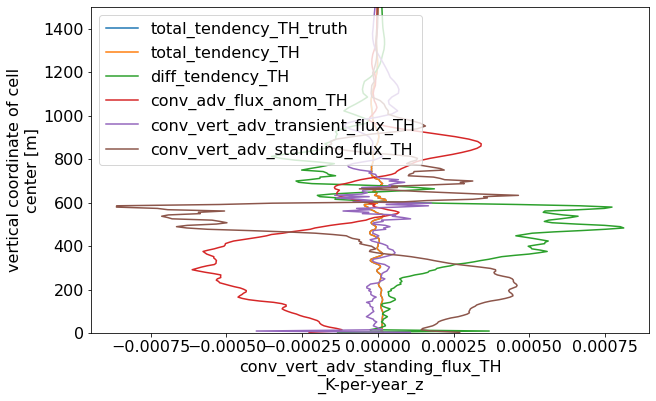

In [9]:
for label in labels.keys():
    ds[f"{label}_K-per-year_z"].rolling({"Z":4}).mean().plot(y="Z", label=label)
plt.legend()
plt.ylim(0, 1500)
#plt.xlim(-10, 10)

(-0.1, 0.1)

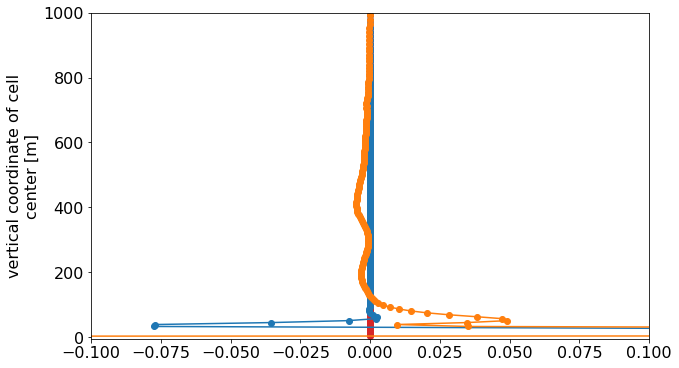

In [10]:
ds = data["idealized-plane"]
((-(ds["diff_tendency_TH"]/ds['drF']).diff(dim="Z")/ds['drF'])/ds["a"]).plot(y="Z", c="C3", marker="o", label="mix")
(-(ds["conv_adv_flux_anom_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C0", marker="o", label="mean")
(-(ds["conv_vert_adv_flux_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C1", marker="o", label="eddy")
#plt.ylim([-5, 100])
#data["idealized-plane"]["conv_adv_flux_anom_TH"].diff(dim="Z").plot(y="Z", marker="o")
plt.ylim([-5, 1000])
plt.xlim(-1e-1, 1e-1)

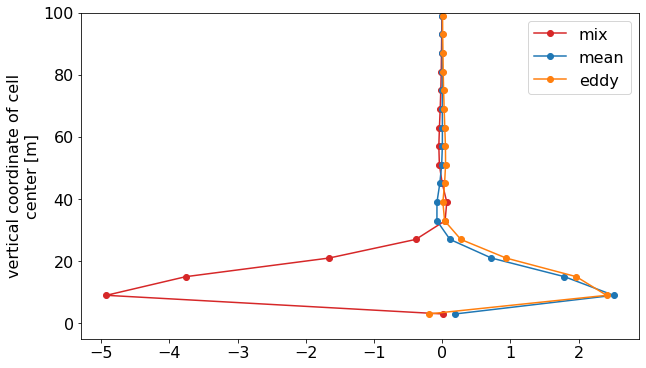

In [11]:
ds = data["idealized-plane"]
(-(ds["diff_tendency_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C3", marker="o", label="mix")
(-(ds["conv_adv_flux_anom_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C0", marker="o", label="mean")
(-(ds["conv_vert_adv_flux_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C1", marker="o", label="eddy")
#plt.ylim([-5, 100])
#data["idealized-plane"]["conv_adv_flux_anom_TH"].diff(dim="Z").plot(y="Z", marker="o")
plt.ylim([-5, 100])
plt.legend()

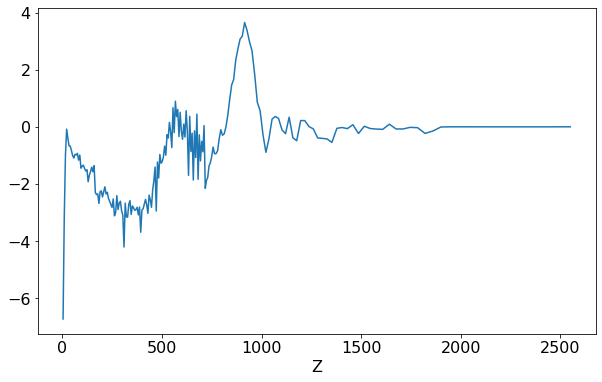

In [12]:
ds = data["canyon-tracer"]
((ds["conv_adv_flux_anom_TH"].diff(dim="Z")/ds["Z"].diff(dim="Z"))/ds["a"][1:]).coarsen({"Z": 1}, boundary="trim").mean().plot()

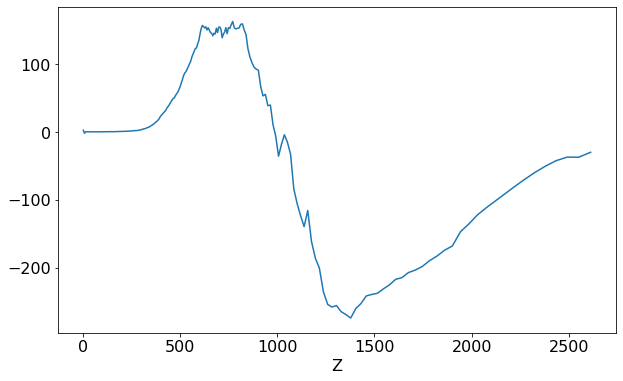

In [13]:
ds["diff_tendency_TH"].coarsen({"Z": 1}, boundary="trim").mean().plot()

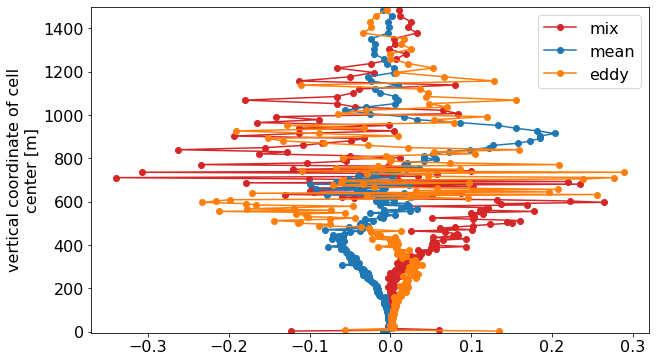

In [14]:
ds = data["canyon-tracer"]
(-(ds["diff_tendency_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C3", marker="o", label="mix")
(-(ds["conv_adv_flux_anom_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C0", marker="o", label="mean")
(-(ds["conv_vert_adv_flux_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C1", marker="o", label="eddy")
#plt.ylim([-5, 100])
#data["idealized-plane"]["conv_adv_flux_anom_TH"].diff(dim="Z").plot(y="Z", marker="o")
plt.ylim([-5, 1500])
plt.legend()

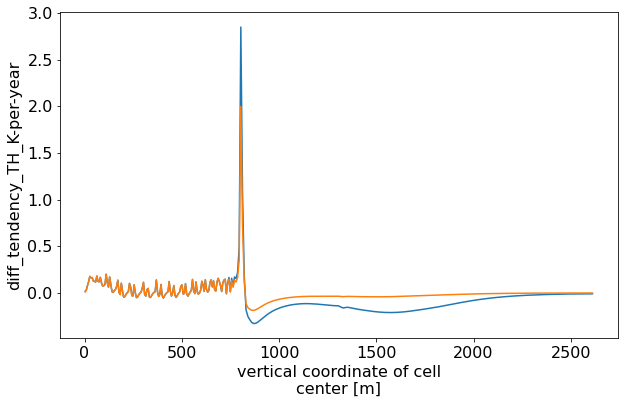

In [51]:
(data["idealized-canyon"][f"diff_tendency_TH_K-per-year"]*ds["drF"]).plot()
((data["idealized-canyon"][f"diff_tendency_TH_K-per-year"])*6).plot()

#### Plotting

In [15]:
import matplotlib.gridspec as gridspec

def break_axes(ax1, ax2, lw=2.5):
    d = .012  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs, lw=lw)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs, lw=lw)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs, lw=lw)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs, lw=lw)  # bottom-right diagonal

idealized-plane-1D
idealized-plane-1D-Pr230
idealized-plane
idealized-canyon
idealized-sill
canyon-tracer


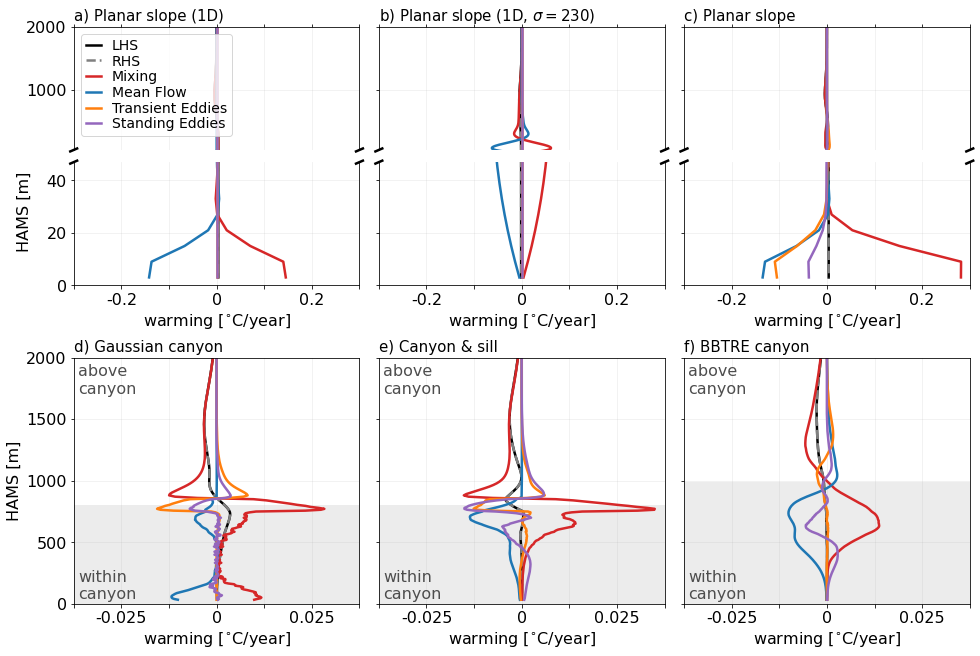

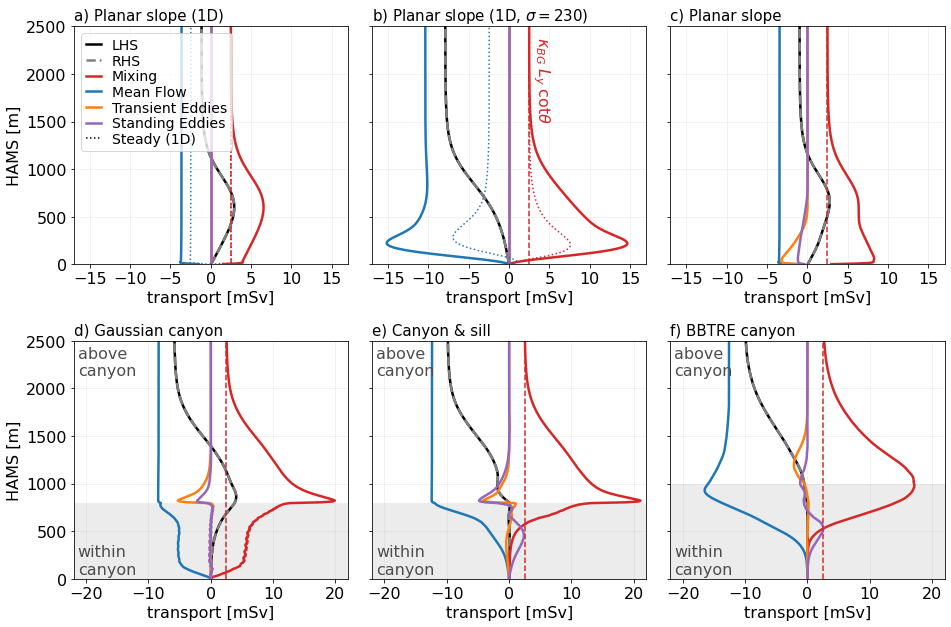

In [64]:
cmap = truncate_colormap(cm.get_cmap('pink'),0.1,1.)

lw = 2.5
nexp = len(experiments)
fig2 = plt.figure(figsize=(13.5,9), constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=4, figure=fig2)
axes2 = np.array([
    [fig2.add_subplot(gs[0, 0]), fig2.add_subplot(gs[0, 1]), fig2.add_subplot(gs[0, 2])],
    [fig2.add_subplot(gs[2:, 0]), fig2.add_subplot(gs[2:, 1]), fig2.add_subplot(gs[2:, 2])],
    [fig2.add_subplot(gs[1, 0]), fig2.add_subplot(gs[1, 1]), fig2.add_subplot(gs[1, 2])],
])

for ax in axes2[0]:
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)
for ax in axes2[2]:
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()

fig3, axes3 = plt.subplots(2, (nexp+1)//2, figsize=(13.5,9))

plabels=["a)", "b)", "c)", "d)", "e)", "f)"]

longnames = {
    'canyon-tracer': "BBTRE canyon",
    'idealized-sill': "Canyon & sill",
    'idealized-canyon': "Gaussian canyon",
    'idealized-plane': "Planar slope",
    'idealized-plane-1D': "Planar slope (1D)",
    'idealized-plane-1D-Pr230': r"Planar slope (1D, $\sigma = 230$)"
}

labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Mixing",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_transient_flux_TH": "Transient Eddies",
    "conv_vert_adv_standing_flux_TH": "Standing Eddies",
}

int_labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Mixing",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_transient_flux_TH": "Transient Eddies",
    "conv_vert_adv_standing_flux_TH": "Standing Eddies",
}

linecolors = ["k", "grey", "C3", "C0", "C1", "C4"]
linestyles = ["-", "--",   "-",   "-", "-",  "-"]
    
cutoffs=[50, 50, 50]

for i, (k,v) in enumerate(data.items()):
    print(k, end="\n")

    Lx, Ly = v.XC.size*dx, v.YC.size*dy
    Ly_ref = 60.e3
    cint = k0*Γ*np.cos(θ)*Ly*Lx
    cbot = k1*Γ*np.cos(θ)*Ly*Lx
    
    for ii, var in enumerate(labels.keys()):
        rolling=1
        if i>2: rolling=12
        v[f"{var}_K-per-year"].rolling({"Z": rolling}, center=True).mean().plot(ax=axes2.flatten()[i], y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyles[ii], lw=lw)
        if i<=2:
            v[f"{var}_K-per-year"].plot(ax=axes2.flatten()[i+6], y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyles[ii], lw=lw)
        v[f"{var}_cumint_mSv"].plot(ax=axes3.flatten()[i], y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyles[ii], lw=lw)

    if i<=2:
        axes2.flatten()[i].set_xlabel(r"")
        axes2.flatten()[i+6].set_xlabel(r"warming [$^{\circ}$C/year]")
    else:
        axes2.flatten()[i].set_xlabel(r"warming [$^{\circ}$C/year]")
    
    axes2.flatten()[i].set_title(f"{plabels[i]} {longnames[k]}", fontsize=15, loc="left")
    
    axes3.flatten()[i].axvline(cint/(Γ*np.sin(θ)*Lx*Ly)*(Ly_ref*1e-3), linestyle='--', color='C3')
    axes3.flatten()[i].set_xlabel("transport [mSv]")
    axes3.flatten()[i].set_title(f"{plabels[i]} {longnames[k]}", fontsize=15, loc="left")
    if i==1:
        axes3.flatten()[i].annotate(r"$\kappa_{BG}\; L_{y}\; \cot{\theta}$", (0.58, 0.62), xycoords='axes fraction', color="C3", rotation=-90)
    axes2_xticks=np.arange(-0.3, 0.4, 0.1)
    axes2_xticklabels = np.array([None, -0.2, None, 0, None, 0.2, None])
    axes2_xlims=np.array([-0.3, 0.3])
    if i<=2:
        axes2.flatten()[i].set_xticks(axes2_xticks)
        axes2.flatten()[i].set_xlim(axes2_xlims)
        axes2.flatten()[i].set_xticklabels([])
        axes2.flatten()[i+6].set_xticks(axes2_xticks)
        axes2.flatten()[i+6].set_xticklabels(axes2_xticklabels)
        axes2.flatten()[i+6].set_xlim(axes2_xlims)
        
        axes3.flatten()[i].set_xticks(np.arange(-15, 20, 5))
        #axes3.flatten()[i].set_xticklabels([-10, None, 0, None, 10])
        axes3.flatten()[i].set_xlim([-17, 17])
    else:
        axes2.flatten()[i].set_xticks(axes2_xticks/4)
        axes2.flatten()[i].set_xticklabels(np.array([None, -0.1/4, None, 0, None, 0.1/4, None]))
        axes2.flatten()[i].set_xlim(axes2_xlims/4)
        axes3.flatten()[i].set_xlim([-22, 22])

    if i<=2:
        axes2.flatten()[i].set_ylim(cutoffs[i]+3, 2000)
        axes2.flatten()[i+6].set_ylim(0, cutoffs[i]-3)
    else:
        axes2.flatten()[i].set_ylim(0, 2000)
    axes3.flatten()[i].set_ylim([0, 2500])
    axlist = [axes2.flatten()[i], axes3.flatten()[i]]
    if i<=2: axlist.append(axes2.flatten()[i+6])
    for axi, ax in enumerate(axlist):
        ax.grid(True, alpha=0.2)
        if (i==0) | (i==3):
            ax.set_ylabel("HAMS [m]")
            if (i==0) & (axi<2):
                if axi==1: ax.plot([], [], "k:", label="Steady (1D)")
                ax.legend(loc="upper left", handlelength=1.08, labelspacing=0.12, borderpad=0.35, fontsize=14)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        ax.fill_between(ax.get_xlim(), [0., 0.], v['crest_HAMS'].values*np.array([1, 1]), lw=5., alpha=0.15, facecolor="grey")
        if i>2:
            ax.annotate("within\ncanyon", xy=(0.015, 0.02), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)
            ax.annotate("above\ncanyon", xy=(0.015, 0.855), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)

for (i, σ) in enumerate([1, 230]):
    oneD = bbl_exp(k0, k1, h, N, f, θ, σ=σ)
    oneD['k'] = k_exp(k0, k1, h, oneD['zf'])
    oneD['dz'] = oneD['zf'][1:] - oneD['zf'][:-1]
    oneD['kbz_term'] = oneD['k']*oneD['bz']/(N**2 * np.sin(θ))*Ly_ref
    oneD['ψ_term'] = -np.cumsum(oneD['u']*oneD['dz'])*Ly_ref

    ax = axes3.flatten()[i]
    ax.plot(oneD['kbz_term']*1e-3, oneD['zf'], "C3:")
    ax.plot(oneD['ψ_term']*1e-3, oneD['z'], "C0:")
        
for axi, ax in enumerate(axes2[2]):
    ax.set_ylabel("")
    if axi>0: ax.set_yticklabels([])
    
for i in range(0,3):
    break_axes(axes2[0][i], axes2[2][i])
axes2[0][0].set_ylabel("")
axes3[1,0].set_ylabel("HAMS [m]")
fig3.tight_layout()

axes2[2][0].annotate(text="HAMS [m]", xy=(-0.2, 0.3), xycoords="axes fraction", rotation=90)

fig2.savefig(f"../../figures/BBTRE/buoyancy_budget.png", dpi=150., bbox_inches='tight')
fig3.savefig(f"../../figures/BBTRE/integral_buoyancy_budget.png", dpi=150., bbox_inches='tight')

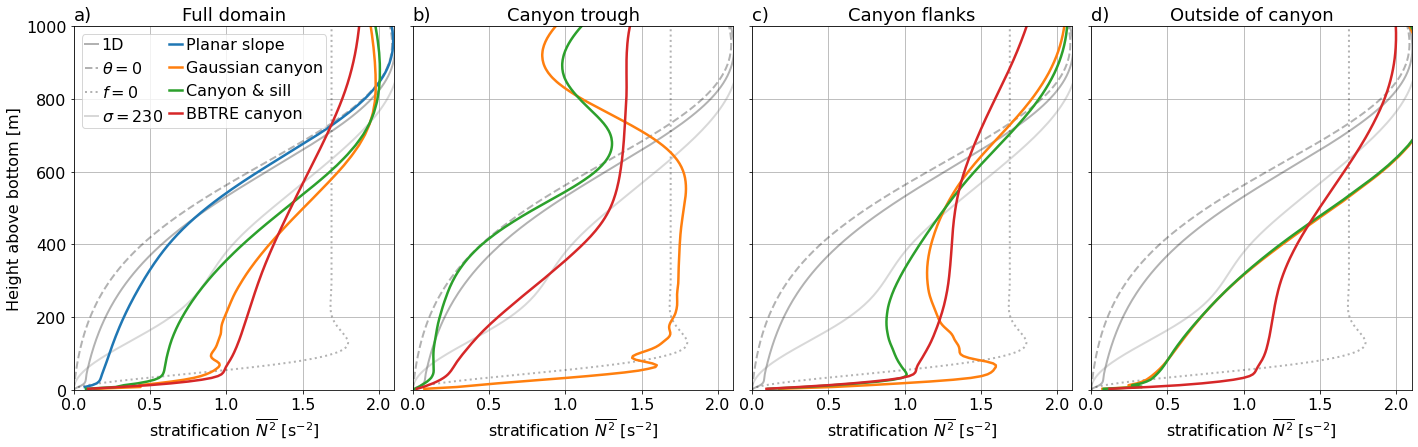

In [246]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6.5))

expcolors = {
    'canyon-tracer': "C3",
    'idealized-sill': "C2",
    'idealized-canyon': "C1",
    'idealized-plane': "C0"
}
titles = ['Full domain', 'Canyon trough', 'Canyon flanks', 'Outside of canyon']
labels = ['a)', 'b)', 'c)', 'd)']
Nsq_names = ["", "_trough", "_flanks", "_outside"]

for i, ax in enumerate(axes):
    bbl_output['default']['bz'].plot(ax=ax, y='Zl', color="k", linestyle='-', label=r"1D", lw=2., alpha=0.3)
    bbl_output['theta=0']['bz'].plot(ax=ax, y='Zl', color="k", linestyle='--', label=r"$\theta = 0$", lw=2., alpha=0.3)
    bbl_output['f=0']['bz'].plot(ax=ax, y='Zl', color="k", linestyle=':', label=r"$f=0$", lw=2., alpha=0.3)
    bbl_output['Pr=230']['bz'].plot(ax=ax, y='Zl', color="grey", label=r"$\sigma=230$", lw=2., alpha=0.3)
    for exp in experiments:
        if (exp=='idealized-plane-1D-Pr230'): continue
        if (exp=='idealized-plane-1D'): continue
        if (exp=='idealized-plane') & (i>0): continue
        ds = data[exp]
        ds[f'Nsq{Nsq_names[i]}'].plot(ax=ax, y='habC', label=longnames[exp], color=expcolors[exp], lw=2.5)
    ticks = np.arange(0., 2.5, 0.5)
    ax.set_xticks(ticks*1.e-6)
    ax.set_xticklabels(ticks)
    if i==0:
        ax.legend(loc='upper left', ncol=2, handlelength=0.8, columnspacing=0.4, borderpad=0.2, handletextpad=0.25)
        ax.set_ylabel("Height above bottom [m]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xlabel("stratification $\overline{N^{2}}$ [s$^{-2}$]")
    ax.set_ylim(0, 1000)
    ax.set_xlim([0, 2.1e-6])
    ax.grid(True)
    ax.set_title(titles[i], fontsize=18)
    ax.set_title(labels[i], loc='left', fontsize=18)
plt.tight_layout(w_pad=-0.25)
plt.savefig(f"../../figures/BBTRE/hab_stratification.png", dpi=150., bbox_inches="tight")